# Mean-Field AOA

In [1]:
import numpy as np
import h5py

In [2]:
import sys, copy
sys.path.append('../src')
from meanfieldaoa import *

## Sherrington-Kirkpatrick

In [3]:
# schedule
p = 1000
τ = 0.5

γ = τ * (np.arange(1, p + 1) - 1/2) / p
β = τ * (1 - np.arange(1, p + 1) / p)
β[p-1] = τ / (4 * p)

In [4]:
# path to folder with the h5 files
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Averaged_MF_energy/"
# PATH = "/home/lappet/Archives/projects/QuantumComputing/QAA_and_MFQAOA/data/mean-field-qaoa/results/sherrington-kirkpatrick/new/"
PATH = "../data/SK_model/"

### Raw data

In [ ]:
seed = 137
np.random.seed(seed)

In [ ]:
# for num in [10 + k * 5 for k in range(23)]:
for num in [180]:
    N = num
    num_instances = 10000

    file = "SK_model_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
    print(file)

    h5_file = h5py.File(PATH + file, "w")

    # Sherrington-Kirkpatrick model
    from tqdm import tqdm
    for i in tqdm(range(num_instances)):
        J = np.random.normal(0, 1, size=(N, N)) / np.sqrt(N)
        J = np.triu(J, k=1)
        J = J + J.transpose()

        S = np.array([[1., 0., 0.] for _ in range(N - 1)]) # fix final spin (i.e. leave it out)
        S = evolve(S, J, β, γ)

        h5_file.create_dataset("set_" + str(i + 1) + "/J", data=J)
        h5_file.create_dataset("set_" + str(i + 1) + "/S_z", data=S[:, 2])

    h5_file.close()

### Histogram statistics

In [ ]:
seed = 137
np.random.seed(seed)

N = 9
num_instances = 10000

file = "SK_model_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
print(file)    
data_file = h5py.File(PATH + file, "r")

E_stars = []
for i in range(num_instances):
    J = data_file["set_" + str(i + 1) + "/J"][:]
    S_z = data_file["set_" + str(i + 1) + "/S_z"][:]

    E_star = expectation(solution(S_z), J)
    E_stars.append(E_star)

file = "SK_model_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + "_hist_stats.h5"    
out_file = h5py.File(PATH_DB + file, "w")
out_file.create_dataset("all_E_stars", data=E_stars)
out_file.close()

### Moments

In [ ]:
E_0 = -0.763

# for num in [10 + k * 5 for k in range(23)]:
for num in [150, 180]:
    N = num
    num_instances = 10000

    file = "SK_model_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
    print(file)    
    data_file = h5py.File(PATH + file, "r")

    E_star = 0
    E_star_squared = 0
    for i in range(num_instances):
        J = data_file["set_" + str(i + 1) + "/J"][:]
        S_z = data_file["set_" + str(i + 1) + "/S_z"][:]

        E_star += expectation(solution(S_z), J)
        E_star_squared += expectation(solution(S_z), J)**2
        
    out_file = h5py.File(PATH_DB + file, "w")
    out_file.create_dataset("E_star", data=[E_star / num_instances])
    out_file.create_dataset("E_star_squared", data=[E_star_squared / num_instances])
    out_file.close()

## Number Partitioning

In [ ]:
# schedule
p = 10000
τ = 0.25

γ = τ * (np.arange(1, p + 1) - 1/2) / p
β = τ * (1 - np.arange(1, p + 1) / p)
β[p-1] = τ / (4 * p)

In [ ]:
PATH = "../data/number-partitioning/"
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/NP_problem/new/"

### Raw data

In [ ]:
# PATH = "../data/number-partitioning/instances/batch_06/"

# X = np.linspace(4, 20, 9, dtype=int)
# ENSEMBLE_SIZE = 100

# for n in X:
#     for i in range(ENSEMBLE_SIZE):
        
#         filename = "number_partitioning_num_{0:02d}".format(n) + "_replica_{0:03d}".format(i + 1)
#         print(i, ", ", filename, "\n")
        
#         a = np.load(PATH + filename + ".npy")
#         J = -2 * np.outer(a.T, a)
#         np.fill_diagonal(J, 0.)    
        
#         # freeze final spin to +1
#         h_z = J[-1, :-1]
#         J = J[:-1, :-1]
#         print(J, "\n")

In [ ]:
X = np.linspace(4, 20, 9, dtype=int)
X = np.concatenate((X, np.array([50, 60, 70, 80, 90, 100, 150, 200])))

In [ ]:
for N in X:
    seed = 137
    np.random.seed(seed)
    num_instances = 10000

    file = "number-partitioning_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
    print(file)

    h5_file = h5py.File(PATH + file, "w")

    # Number partitioning
    from tqdm import tqdm
    for i in tqdm(range(num_instances)):
        a = np.random.uniform(0, 1, size=N) 
        a = np.sort(a)
        J = -2 * np.outer(a.T, a)
        np.fill_diagonal(J, 0.)    
        
        S = np.array([[1., 0., 0.] for _ in range(N - 1)]) # fix final spin (i.e. leave it out)
        S = evolve(S, J, β, γ)

        h5_file.create_dataset("set_" + str(i + 1) + "/a", data=a)
        h5_file.create_dataset("set_" + str(i + 1) + "/S_z", data=S[:, 2])

    h5_file.close()        

### Histogram statistics

In [ ]:
seed = 137
np.random.seed(seed)

N = 50
num_instances = 10000

file = "number-partitioning_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
print(file)    
data_file = h5py.File(PATH + file, "r")

E_stars = []
for i in range(num_instances):
    a = data_file["set_" + str(i + 1) + "/a"][:]
    S_z = data_file["set_" + str(i + 1) + "/S_z"][:]
    
    J = -2 * np.outer(a.T, a)
    np.fill_diagonal(J, 0.)   
    
    E_and_string = (np.sum(a**2) + expectation(solution(S_z), J), S_z)
    
#     # one spin flip
#     for j in range(S_z.shape[0]):
#         new_S_z = copy.deepcopy(S_z)
#         new_S_z[j] *= -1
#         if E_and_string[0] > np.sum(a**2) + expectation(solution(new_S_z), J):
#             E_and_string = (np.sum(a**2) + expectation(solution(new_S_z), J), new_S_z)

    # two spin flips
    for j in range(S_z.shape[0]):
        for k in range(j + 1, S_z.shape[0]):
            new_S_z = copy.deepcopy(S_z)
            new_S_z[j] *= -1
            new_S_z[k] *= -1
            if E_and_string[0] > np.sum(a**2) + expectation(solution(new_S_z), J):
                E_and_string = (np.sum(a**2) + expectation(solution(new_S_z), J), new_S_z)
    
    E_stars.append(np.sqrt(E_and_string[0]))

file = "number-partitioning_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + "_hist_stats.h5"    
out_file = h5py.File(PATH + file, "w")
out_file.create_dataset("all_E_stars", data=E_stars)
out_file.close()

### Moments

In [ ]:
X = np.arange(10, 22, 2);
X = np.concatenate((X, [25 + 5*k for k in range(5)], [50, 60, 70, 80, 90]))
X

In [ ]:
for N in X:
# for N in [25, 30, 35, 40, 45]:
    seed = 137
    num_instances = 10000

    file = "number-partitioning_" + "p_" + str(p) + "_N_" + str(N) + "_num_inst_" + str(num_instances) + "_seed_" + str(seed) + ".h5"
    print(file)    
    data_file = h5py.File(PATH + file, "r")

    E_star_sqrt = 0
    for i in range(num_instances):
        a = data_file["set_" + str(i + 1) + "/a"][:]
        S_z = data_file["set_" + str(i + 1) + "/S_z"][:]

        J = -2 * np.outer(a.T, a)
        np.fill_diagonal(J, 0.)

        E_star = np.sum(a**2) + expectation(solution(S_z), J)

        # two spin flips
        for j in range(S_z.shape[0]):
            for k in range(j + 1, S_z.shape[0]):
                new_S_z = copy.deepcopy(S_z)
                new_S_z[j] *= -1
                new_S_z[k] *= -1
                if E_star > np.sum(a**2) + expectation(solution(new_S_z), J):
                    E_star = np.sum(a**2) + expectation(solution(new_S_z), J)

        E_star_sqrt += np.sqrt(E_star)
        
    out_file = h5py.File(PATH + file[:-3] + "_moments.h5", "w")
    out_file.create_dataset("E_star_sqrt", data=[E_star_sqrt / num_instances])
    out_file.close()

## Testing

### Explicit time evolution

In [3]:
# schedule
T = 10.
n = 2**10
Δt = T/n
times = np.linspace(0, T, n + 1)

p = n
γ = np.array([Δt for j in range(p)])
β = np.array([Δt for j in range(p)])

In [4]:
N = 3

J = np.triu(np.ones((N, N)), k=1) 
J += J.transpose()

In [5]:
J[:N-1, :N-1]

array([[0., 1.],
       [1., 0.]])

In [6]:
S = np.array([[1., 0., 0.] for _ in range(N - 1)]) # fix final spin (i.e. leave it out)
data = np.array([S for _ in range(p+1)])
for k in range(p):
    S = evolve(S, J, np.array([Δt]), np.array([Δt]))
    data[k + 1] = S

In [26]:
from scipy.integrate import solve_ivp

def S(t, y, B, C):
    h = J[N-1, :-1]
    Δ = np.ones(N - 1)
    m_0 = h[0] + J[0, 1] * y[3 + 2]
    m_1 = h[1] + J[1, 0] * y[0 + 2]
    return [2 * C * m_0  * y[0 + 1], 
            2 * B * Δ[0] * y[0 + 2] - 2 * C * m_0 * y[0 + 0],
           -2 * B * Δ[0] * y[0 + 1],
            2 * C * m_1  * y[3 + 1], 
            2 * B * Δ[1] * y[3 + 2] - 2 * C * m_1 * y[3 + 0],
           -2 * B * Δ[1] * y[3 + 1]]

init = [1., 0., 0., 1., 0., 0.]
test_data = np.array([init for _ in range(n+1)])
for i in range(n):
    # do a problem step
    sol = solve_ivp(S, [0, Δt], init, t_eval=[Δt], args=(0., 1.))
    init = sol.y.flatten()
    
    # then do a driver step
    sol = solve_ivp(S, [0, Δt], init, t_eval=[Δt], args=(1., 0.))
    init = sol.y.flatten()
    
    test_data[i+1] = sol.y.flatten()

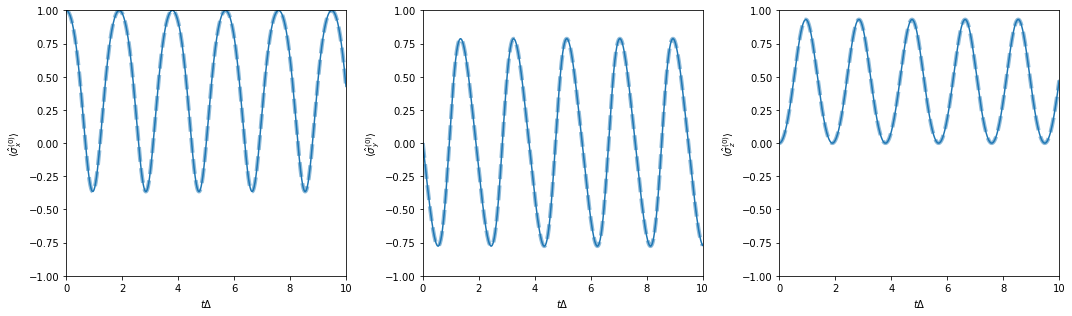

In [27]:
import matplotlib.pyplot as plt
spin_nr = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
ylabels = ["$\\langle\hat{\sigma}_"+s+"^{("+str(spin_nr)+")}\\rangle$" for s in ["x", "y", "z"]]
for k in range(3):
    ax[k].plot(times, data[:, spin_nr, k], "-")
    ax[k].plot(times, test_data[:, k], "--C0", alpha=0.5, lw=4)
    ax[k].set_xlim(0, T)
    ax[k].set_ylim(-1, 1)
    ax[k].set_xlabel("$t \Delta $")
    ax[k].set_ylabel(ylabels[k])
plt.tight_layout()

In [31]:
digits = 7
assert (np.round(data[:, 0, 0] - test_data.T[0], decimals=digits) == 0.0).all()
assert (np.round(data[:, 0, 1] - test_data.T[1], decimals=digits) == 0.0).all()
assert (np.round(data[:, 0, 2] - test_data.T[2], decimals=digits) == 0.0).all()